<a href="https://colab.research.google.com/github/haricharanvihari/extensive_viz/blob/master/S6_DNN/S6_EVA4S6F10_Haricharan_Vihari_N_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [0]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


##Defining the Batch Norm and GBN

In [0]:
class BatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, eps=1e-05, momentum=0.1, weight=True, bias=True):
        super().__init__(num_features, eps=eps, momentum=momentum)
        self.weight.data.fill_(1.0)
        self.bias.data.fill_(0.0)
        self.weight.requires_grad = weight
        self.bias.requires_grad = bias


class GhostBatchNorm(BatchNorm):
    def __init__(self, num_features, num_splits, **kw):
        super().__init__(num_features, **kw)
        self.num_splits = num_splits
        self.register_buffer('running_mean', torch.zeros(num_features * self.num_splits))
        self.register_buffer('running_var', torch.ones(num_features * self.num_splits))

    def train(self, mode=True):
        if (self.training is True) and (mode is False):  # lazily collate stats when we are going to use them
            self.running_mean = torch.mean(self.running_mean.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
            self.running_var = torch.mean(self.running_var.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
        return super().train(mode)

    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            return F.batch_norm(
                input.view(-1, C * self.num_splits, H, W), self.running_mean, self.running_var,
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W)
        else:
            return F.batch_norm(
                input, self.running_mean[:self.num_features], self.running_var[:self.num_features],
                self.weight, self.bias, False, self.momentum, self.eps)

# The model
Let's start with the model we first saw

In [0]:
import torch.nn.functional as F
# dropout_value = 0.1
# dropout_value = 0.1
# num_splits = 1

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.dropout_value = 0.1
        self.ghostbatchnorm = False
        self.num_splits = 1

        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            #nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            #nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
             nn.BatchNorm2d(20),
             nn.ReLU(),
             #nn.Dropout(dropout_value)
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(10),
            #nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(10),
            #nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(20),
            #nn.Dropout(dropout_value)
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(10),
            #nn.Dropout(dropout_value)
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 


        #self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

    def set_GBN(self, is_ghostbatchnorm = False, splits = 1):
        self.ghostbatchnorm = is_ghostbatchnorm
        self.num_splits = splits

    def batchnorm(self, num_features):
        if self.ghostbatchnorm and self.ghostbatchnorm == True:
            return GhostBatchNorm(num_features, self.num_splits)
        else:
            return BatchNorm(num_features)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [0]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
            Conv2d-4           [-1, 10, 24, 24]             900
              ReLU-5           [-1, 10, 24, 24]               0
       BatchNorm2d-6           [-1, 10, 24, 24]              20
            Conv2d-7           [-1, 20, 22, 22]           1,800
       BatchNorm2d-8           [-1, 20, 22, 22]              40
              ReLU-9           [-1, 20, 22, 22]               0
        MaxPool2d-10           [-1, 20, 11, 11]               0
           Conv2d-11           [-1, 10, 11, 11]             200
             ReLU-12           [-1, 10, 11, 11]               0
      BatchNorm2d-13           [-1, 10, 11, 11]              20
           Conv2d-14             [

##Plotting

In [0]:
# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

def plot_matrix(matrix_data, matrix):
    fig = plt.figure(figsize=(10, 10))
    
    plt.title(f'Validation %s' % (matrix))
    plt.xlabel('Epoch')
    plt.ylabel(matrix)

    plt_t = ()
    legend_t = ()
    for key in matrix_data:
        if matrix.lower() in matrix_data[key]:
            plt_t = plt_t + (plt.plot(matrix_data[key][matrix.lower()])[0], )
            legend_t = legend_t + (key, )
    
    plt.legend(plt_t, legend_t)

    fig.savefig(f'val_%s_change.png' % (matrix.lower()))

def plot_misclassified(matrix_data, matrix):
  fig = plt.figure(figsize = (10,10))

  for key in matrix_data:
        if matrix.lower() == key.lower():
            mc_matrix = matrix_data[key]["misclassified"]

            for i in range(25):
                  sub = fig.add_subplot(5, 5, i+1)
                  plt.imshow(mc_matrix[i][0].cpu().numpy().squeeze(),cmap='gray',interpolation='none')
                  
                  sub.set_title("Pred={}, Act={}".format(str(mc_matrix[i][1].data.cpu().numpy()),str(mc_matrix[i][2].data.cpu().numpy())))
                  
            plt.tight_layout()

            plt.show()

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
train_acc = []

def train(model, device, train_loader, optimizer, epoch, L1 = 0):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    if L1 > 0:
      l1_crit = nn.L1Loss(size_average = False).to(device)
      l1_loss = 0
      for param in model.parameters():
        zero_vector = torch.rand_like(param) * 0
        l1_loss += l1_crit(param, zero_vector)
      factor = 0.0005
      loss += factor * l1_loss
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)
    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader, test_losses, test_acc, misclassified, case_misclassified = False):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            if case_misclassified == True:
                for i in range(len(pred)):
                    if pred[i] != target[i]:
                        misclassified.append([data[i], pred[i], target[i]])
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

    return test_losses, test_acc, misclassified

In [0]:
from torch.optim.lr_scheduler import StepLR

matrix_data = {}

EPOCHS = 25

def run_model(heading, data_key, is_GBN, l1_norm, l2_norm, case_misclassified = False):
    print(heading)
    net_model = Net()
    if is_GBN == True:
        net_model.set_GBN(True, 8)
    else:
        net_model.set_GBN(False)
    model =  net_model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay = l2_norm)
    scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

    test_losses = []
    test_acc = []
    misclassified = []
    for epoch in range(EPOCHS):
        print("EPOCH:", epoch + 1)
        train(model, device, train_loader, optimizer, epoch, L1 = l1_norm)
        # scheduler.step()
        test_losses, test_acc, misclassified = test(model, device, test_loader, test_losses, test_acc, misclassified, case_misclassified = case_misclassified)
    matrix_data[data_key] = {"loss":test_losses, "accuracy":test_acc, "misclassified":misclassified}

## Without L1/L2 with BN

In [0]:
run_model("Without L1/L2 with BN", "BN", False, 0, 0, case_misclassified = True)

  0%|          | 0/469 [00:00<?, ?it/s]

**** Without L1/L2 with BN ****
EPOCH: 1


Loss=0.24965888261795044 Batch_id=468 Accuracy=84.29: 100%|██████████| 469/469 [00:22<00:00, 20.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1178, Accuracy: 9718/10000 (97.18%)

EPOCH: 2


Loss=0.205744668841362 Batch_id=468 Accuracy=97.07: 100%|██████████| 469/469 [00:23<00:00, 19.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0770, Accuracy: 9799/10000 (97.99%)

EPOCH: 3


Loss=0.2125432938337326 Batch_id=468 Accuracy=97.73: 100%|██████████| 469/469 [00:22<00:00, 20.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0582, Accuracy: 9846/10000 (98.46%)

EPOCH: 4


Loss=0.03460032865405083 Batch_id=468 Accuracy=98.07: 100%|██████████| 469/469 [00:22<00:00, 20.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0588, Accuracy: 9836/10000 (98.36%)

EPOCH: 5


Loss=0.028454655781388283 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:22<00:00, 20.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0443, Accuracy: 9864/10000 (98.64%)

EPOCH: 6


Loss=0.02585497498512268 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:23<00:00, 20.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0380, Accuracy: 9899/10000 (98.99%)

EPOCH: 7


Loss=0.08301462978124619 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:23<00:00, 19.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0422, Accuracy: 9885/10000 (98.85%)

EPOCH: 8


Loss=0.09325244277715683 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:23<00:00, 20.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0376, Accuracy: 9900/10000 (99.00%)

EPOCH: 9


Loss=0.03831654414534569 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:23<00:00, 20.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0318, Accuracy: 9907/10000 (99.07%)

EPOCH: 10


Loss=0.02898448146879673 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:23<00:00, 20.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0351, Accuracy: 9907/10000 (99.07%)

EPOCH: 11


Loss=0.03672716021537781 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:23<00:00, 19.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0323, Accuracy: 9903/10000 (99.03%)

EPOCH: 12


Loss=0.007600294891744852 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:22<00:00, 20.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0298, Accuracy: 9914/10000 (99.14%)

EPOCH: 13


Loss=0.049287352710962296 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:22<00:00, 20.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0295, Accuracy: 9915/10000 (99.15%)

EPOCH: 14


Loss=0.04998374357819557 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:23<00:00, 20.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0331, Accuracy: 9895/10000 (98.95%)

EPOCH: 15


Loss=0.02655164897441864 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:24<00:00, 19.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0293, Accuracy: 9910/10000 (99.10%)

EPOCH: 16


Loss=0.016982361674308777 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:23<00:00, 20.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0316, Accuracy: 9908/10000 (99.08%)

EPOCH: 17


Loss=0.015700196847319603 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:23<00:00, 20.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0297, Accuracy: 9914/10000 (99.14%)

EPOCH: 18


Loss=0.01305264700204134 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:23<00:00, 20.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0314, Accuracy: 9906/10000 (99.06%)

EPOCH: 19


Loss=0.02908160351216793 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:23<00:00, 19.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0267, Accuracy: 9920/10000 (99.20%)

EPOCH: 20


Loss=0.015404035337269306 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:22<00:00, 20.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0304, Accuracy: 9903/10000 (99.03%)

EPOCH: 21


Loss=0.009311388246715069 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:22<00:00, 20.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Accuracy: 9921/10000 (99.21%)

EPOCH: 22


Loss=0.02476823888719082 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:23<00:00, 20.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0295, Accuracy: 9919/10000 (99.19%)

EPOCH: 23


Loss=0.09712719172239304 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:23<00:00, 19.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0246, Accuracy: 9919/10000 (99.19%)

EPOCH: 24


Loss=0.06030699238181114 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:22<00:00, 20.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Accuracy: 9925/10000 (99.25%)

EPOCH: 25


Loss=0.027576148509979248 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:23<00:00, 20.36it/s]



Test set: Average loss: 0.0277, Accuracy: 9925/10000 (99.25%)



## Misclassified images - 25 for Without L1L2 with BN #Plot

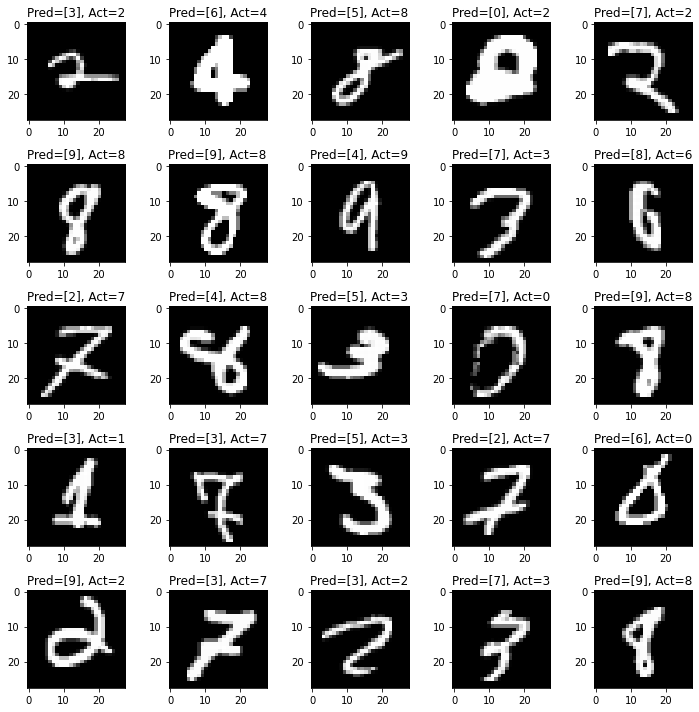

In [0]:
plot_misclassified(matrix_data, "BN")

##Without L1/L2 with GBN

In [0]:
run_model("**** Without L1/L2 with GBN ****", "GBN", True, 0, 0, case_misclassified = True)

  0%|          | 0/469 [00:00<?, ?it/s]

**** Without L1/L2 with GBN ****
EPOCH: 1


Loss=0.12512902915477753 Batch_id=468 Accuracy=85.05: 100%|██████████| 469/469 [00:23<00:00, 20.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1484, Accuracy: 9635/10000 (96.35%)

EPOCH: 2


Loss=0.05787666141986847 Batch_id=468 Accuracy=96.94: 100%|██████████| 469/469 [00:23<00:00, 20.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0959, Accuracy: 9740/10000 (97.40%)

EPOCH: 3


Loss=0.09118742495775223 Batch_id=468 Accuracy=97.66: 100%|██████████| 469/469 [00:22<00:00, 20.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0570, Accuracy: 9843/10000 (98.43%)

EPOCH: 4


Loss=0.054028213024139404 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:22<00:00, 20.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0480, Accuracy: 9877/10000 (98.77%)

EPOCH: 5


Loss=0.025671618059277534 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:23<00:00, 19.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0422, Accuracy: 9885/10000 (98.85%)

EPOCH: 6


Loss=0.06699112802743912 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:23<00:00, 20.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0388, Accuracy: 9894/10000 (98.94%)

EPOCH: 7


Loss=0.01275294553488493 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:22<00:00, 20.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0372, Accuracy: 9892/10000 (98.92%)

EPOCH: 8


Loss=0.04641347751021385 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:22<00:00, 20.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0407, Accuracy: 9885/10000 (98.85%)

EPOCH: 9


Loss=0.05076880380511284 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:23<00:00, 20.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0354, Accuracy: 9904/10000 (99.04%)

EPOCH: 10


Loss=0.01744668185710907 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:23<00:00, 19.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0369, Accuracy: 9894/10000 (98.94%)

EPOCH: 11


Loss=0.10196402668952942 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:23<00:00, 20.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0362, Accuracy: 9888/10000 (98.88%)

EPOCH: 12


Loss=0.02693445049226284 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:22<00:00, 20.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0311, Accuracy: 9911/10000 (99.11%)

EPOCH: 13


Loss=0.05447949841618538 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:22<00:00, 20.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0322, Accuracy: 9911/10000 (99.11%)

EPOCH: 14


Loss=0.014929289929568768 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:23<00:00, 19.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0372, Accuracy: 9885/10000 (98.85%)

EPOCH: 15


Loss=0.022353991866111755 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:23<00:00, 19.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0305, Accuracy: 9910/10000 (99.10%)

EPOCH: 16


Loss=0.0485675148665905 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:23<00:00, 20.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0283, Accuracy: 9917/10000 (99.17%)

EPOCH: 17


Loss=0.008564849384129047 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:23<00:00, 20.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0280, Accuracy: 9921/10000 (99.21%)

EPOCH: 18


Loss=0.003980631474405527 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:23<00:00, 20.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0274, Accuracy: 9930/10000 (99.30%)

EPOCH: 19


Loss=0.0024327386636286974 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:23<00:00, 19.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0278, Accuracy: 9920/10000 (99.20%)

EPOCH: 20


Loss=0.03867700695991516 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:22<00:00, 20.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0278, Accuracy: 9919/10000 (99.19%)

EPOCH: 21


Loss=0.016151010990142822 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:22<00:00, 20.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0264, Accuracy: 9925/10000 (99.25%)

EPOCH: 22


Loss=0.011741037480533123 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:24<00:00, 19.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0291, Accuracy: 9920/10000 (99.20%)

EPOCH: 23


Loss=0.026708299294114113 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:23<00:00, 20.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0292, Accuracy: 9909/10000 (99.09%)

EPOCH: 24


Loss=0.03021075762808323 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:22<00:00, 20.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0262, Accuracy: 9916/10000 (99.16%)

EPOCH: 25


Loss=0.031467463821172714 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:23<00:00, 20.01it/s]



Test set: Average loss: 0.0291, Accuracy: 9913/10000 (99.13%)



##Misclassified images - 25 for Without L1L2 with GBN #Plot

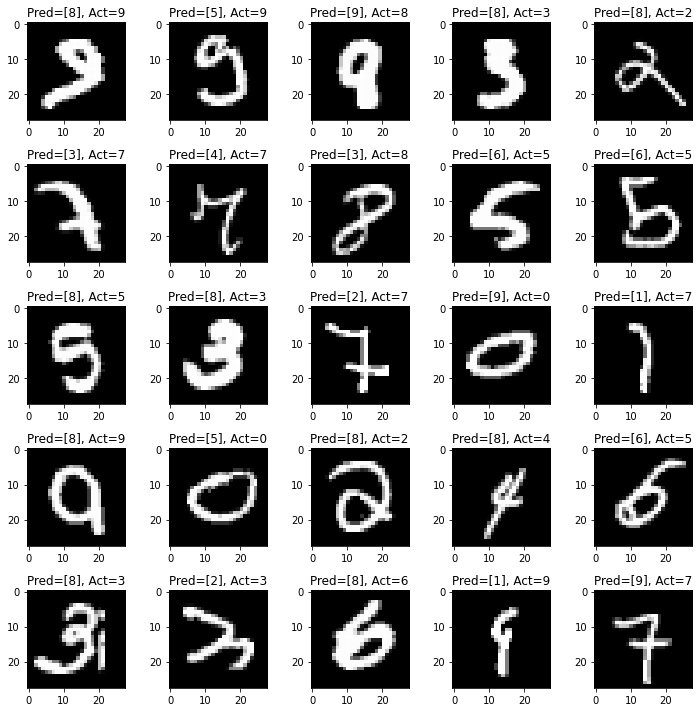

In [0]:
plot_misclassified(matrix_data, "GBN")

##With L1, BN

In [0]:
run_model("**** With L1 with BN ****", "L1BN", False, 0.00005, 0)

  0%|          | 0/469 [00:00<?, ?it/s]

**** With L1 with BN ****
EPOCH: 1


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Loss=0.38436955213546753 Batch_id=468 Accuracy=85.93: 100%|██████████| 469/469 [00:28<00:00, 16.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1168, Accuracy: 9730/10000 (97.30%)

EPOCH: 2


Loss=0.3536533713340759 Batch_id=468 Accuracy=97.00: 100%|██████████| 469/469 [00:26<00:00, 17.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0951, Accuracy: 9744/10000 (97.44%)

EPOCH: 3


Loss=0.27338844537734985 Batch_id=468 Accuracy=97.54: 100%|██████████| 469/469 [00:27<00:00, 17.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0686, Accuracy: 9824/10000 (98.24%)

EPOCH: 4


Loss=0.24079841375350952 Batch_id=468 Accuracy=97.75: 100%|██████████| 469/469 [00:28<00:00, 16.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0542, Accuracy: 9845/10000 (98.45%)

EPOCH: 5


Loss=0.2575839161872864 Batch_id=468 Accuracy=97.85: 100%|██████████| 469/469 [00:27<00:00, 16.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0582, Accuracy: 9838/10000 (98.38%)

EPOCH: 6


Loss=0.2473524659872055 Batch_id=468 Accuracy=97.98: 100%|██████████| 469/469 [00:27<00:00, 16.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0795, Accuracy: 9782/10000 (97.82%)

EPOCH: 7


Loss=0.23212957382202148 Batch_id=468 Accuracy=98.05: 100%|██████████| 469/469 [00:27<00:00, 16.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0530, Accuracy: 9863/10000 (98.63%)

EPOCH: 8


Loss=0.174264058470726 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:27<00:00, 16.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0492, Accuracy: 9867/10000 (98.67%)

EPOCH: 9


Loss=0.20023314654827118 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:26<00:00, 17.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0469, Accuracy: 9865/10000 (98.65%)

EPOCH: 10


Loss=0.17854203283786774 Batch_id=468 Accuracy=98.15: 100%|██████████| 469/469 [00:27<00:00, 16.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0676, Accuracy: 9815/10000 (98.15%)

EPOCH: 11


Loss=0.21710602939128876 Batch_id=468 Accuracy=98.21: 100%|██████████| 469/469 [00:28<00:00, 16.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0495, Accuracy: 9859/10000 (98.59%)

EPOCH: 12


Loss=0.32065361738204956 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:27<00:00, 16.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0512, Accuracy: 9828/10000 (98.28%)

EPOCH: 13


Loss=0.22143548727035522 Batch_id=468 Accuracy=98.24: 100%|██████████| 469/469 [00:27<00:00, 16.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0558, Accuracy: 9840/10000 (98.40%)

EPOCH: 14


Loss=0.19879159331321716 Batch_id=468 Accuracy=98.35: 100%|██████████| 469/469 [00:28<00:00, 16.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0468, Accuracy: 9863/10000 (98.63%)

EPOCH: 15


Loss=0.2567102909088135 Batch_id=468 Accuracy=98.24: 100%|██████████| 469/469 [00:28<00:00, 16.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0425, Accuracy: 9876/10000 (98.76%)

EPOCH: 16


Loss=0.2049294412136078 Batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [00:27<00:00, 17.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0784, Accuracy: 9805/10000 (98.05%)

EPOCH: 17


Loss=0.1659381091594696 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:27<00:00, 17.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0427, Accuracy: 9870/10000 (98.70%)

EPOCH: 18


Loss=0.16809986531734467 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:27<00:00, 17.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0388, Accuracy: 9884/10000 (98.84%)

EPOCH: 19


Loss=0.20283539593219757 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:28<00:00, 16.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0634, Accuracy: 9806/10000 (98.06%)

EPOCH: 20


Loss=0.19398894906044006 Batch_id=468 Accuracy=98.29: 100%|██████████| 469/469 [00:27<00:00, 17.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0414, Accuracy: 9880/10000 (98.80%)

EPOCH: 21


Loss=0.17272475361824036 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:27<00:00, 17.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0616, Accuracy: 9804/10000 (98.04%)

EPOCH: 22


Loss=0.16471725702285767 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:27<00:00, 16.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0433, Accuracy: 9870/10000 (98.70%)

EPOCH: 23


Loss=0.150705948472023 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:28<00:00, 16.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0414, Accuracy: 9884/10000 (98.84%)

EPOCH: 24


Loss=0.1740378737449646 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:26<00:00, 17.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0796, Accuracy: 9772/10000 (97.72%)

EPOCH: 25


Loss=0.2299281656742096 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:27<00:00, 17.33it/s]



Test set: Average loss: 0.0499, Accuracy: 9842/10000 (98.42%)



##With L1, GBN

In [0]:
run_model("**** With L1 with GBN ****", "L1GBN", True, 0.00005, 0)

  0%|          | 0/469 [00:00<?, ?it/s]

**** With L1 with GBN ****
EPOCH: 1


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Loss=0.3704814612865448 Batch_id=468 Accuracy=83.89: 100%|██████████| 469/469 [00:26<00:00, 17.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1842, Accuracy: 9493/10000 (94.93%)

EPOCH: 2


Loss=0.3125284016132355 Batch_id=468 Accuracy=96.85: 100%|██████████| 469/469 [00:28<00:00, 16.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0938, Accuracy: 9735/10000 (97.35%)

EPOCH: 3


Loss=0.2515135109424591 Batch_id=468 Accuracy=97.42: 100%|██████████| 469/469 [00:28<00:00, 16.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0846, Accuracy: 9740/10000 (97.40%)

EPOCH: 4


Loss=0.25581708550453186 Batch_id=468 Accuracy=97.55: 100%|██████████| 469/469 [00:28<00:00, 16.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0765, Accuracy: 9773/10000 (97.73%)

EPOCH: 5


Loss=0.27603644132614136 Batch_id=468 Accuracy=97.92: 100%|██████████| 469/469 [00:28<00:00, 16.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0738, Accuracy: 9781/10000 (97.81%)

EPOCH: 6


Loss=0.26326677203178406 Batch_id=468 Accuracy=97.87: 100%|██████████| 469/469 [00:27<00:00, 16.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0660, Accuracy: 9804/10000 (98.04%)

EPOCH: 7


Loss=0.23099613189697266 Batch_id=468 Accuracy=98.05: 100%|██████████| 469/469 [00:27<00:00, 17.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0531, Accuracy: 9846/10000 (98.46%)

EPOCH: 8


Loss=0.20013859868049622 Batch_id=468 Accuracy=97.98: 100%|██████████| 469/469 [00:28<00:00, 16.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0578, Accuracy: 9829/10000 (98.29%)

EPOCH: 9


Loss=0.22676829993724823 Batch_id=468 Accuracy=98.13: 100%|██████████| 469/469 [00:27<00:00, 16.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0523, Accuracy: 9837/10000 (98.37%)

EPOCH: 10


Loss=0.2663964629173279 Batch_id=468 Accuracy=98.15: 100%|██████████| 469/469 [00:27<00:00, 17.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0675, Accuracy: 9798/10000 (97.98%)

EPOCH: 11


Loss=0.19874486327171326 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:27<00:00, 16.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0607, Accuracy: 9822/10000 (98.22%)

EPOCH: 12


Loss=0.20157890021800995 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:27<00:00, 17.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0544, Accuracy: 9833/10000 (98.33%)

EPOCH: 13


Loss=0.18512111902236938 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:27<00:00, 17.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0421, Accuracy: 9857/10000 (98.57%)

EPOCH: 14


Loss=0.18831101059913635 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:28<00:00, 16.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0548, Accuracy: 9828/10000 (98.28%)

EPOCH: 15


Loss=0.2196083962917328 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:27<00:00, 16.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0445, Accuracy: 9859/10000 (98.59%)

EPOCH: 16


Loss=0.2590957283973694 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:27<00:00, 16.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0501, Accuracy: 9847/10000 (98.47%)

EPOCH: 17


Loss=0.1600370705127716 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:27<00:00, 16.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0615, Accuracy: 9815/10000 (98.15%)

EPOCH: 18


Loss=0.15866930782794952 Batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [00:27<00:00, 17.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0574, Accuracy: 9816/10000 (98.16%)

EPOCH: 19


Loss=0.19647814333438873 Batch_id=468 Accuracy=98.24: 100%|██████████| 469/469 [00:27<00:00, 16.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0434, Accuracy: 9864/10000 (98.64%)

EPOCH: 20


Loss=0.20324426889419556 Batch_id=468 Accuracy=98.35: 100%|██████████| 469/469 [00:28<00:00, 16.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0436, Accuracy: 9859/10000 (98.59%)

EPOCH: 21


Loss=0.1975192129611969 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:27<00:00, 17.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0558, Accuracy: 9828/10000 (98.28%)

EPOCH: 22


Loss=0.1496836096048355 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:27<00:00, 16.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0561, Accuracy: 9816/10000 (98.16%)

EPOCH: 23


Loss=0.19511497020721436 Batch_id=468 Accuracy=98.29: 100%|██████████| 469/469 [00:28<00:00, 16.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0506, Accuracy: 9846/10000 (98.46%)

EPOCH: 24


Loss=0.17045719921588898 Batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [00:27<00:00, 16.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0558, Accuracy: 9825/10000 (98.25%)

EPOCH: 25


Loss=0.1501244455575943 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:27<00:00, 17.07it/s]



Test set: Average loss: 0.0636, Accuracy: 9819/10000 (98.19%)



##With L2, BN

In [0]:
run_model("**** With L2 with BN ****", "L2BN", False, 0, 0.0003)

  0%|          | 0/469 [00:00<?, ?it/s]

**** With L2 with BN ****
EPOCH: 1


Loss=0.16648586094379425 Batch_id=468 Accuracy=82.53: 100%|██████████| 469/469 [00:24<00:00, 19.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1476, Accuracy: 9615/10000 (96.15%)

EPOCH: 2


Loss=0.08923102170228958 Batch_id=468 Accuracy=97.19: 100%|██████████| 469/469 [00:24<00:00, 19.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0630, Accuracy: 9835/10000 (98.35%)

EPOCH: 3


Loss=0.09110978990793228 Batch_id=468 Accuracy=97.78: 100%|██████████| 469/469 [00:24<00:00, 19.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0572, Accuracy: 9844/10000 (98.44%)

EPOCH: 4


Loss=0.1170467957854271 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:24<00:00, 19.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0414, Accuracy: 9889/10000 (98.89%)

EPOCH: 5


Loss=0.06102178990840912 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:24<00:00, 19.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0432, Accuracy: 9881/10000 (98.81%)

EPOCH: 6


Loss=0.04287225380539894 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:24<00:00, 19.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0366, Accuracy: 9895/10000 (98.95%)

EPOCH: 7


Loss=0.016642607748508453 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:24<00:00, 19.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0392, Accuracy: 9889/10000 (98.89%)

EPOCH: 8


Loss=0.02792740799486637 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:24<00:00, 19.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0321, Accuracy: 9912/10000 (99.12%)

EPOCH: 9


Loss=0.018419712781906128 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:24<00:00, 19.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0336, Accuracy: 9903/10000 (99.03%)

EPOCH: 10


Loss=0.06078961119055748 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:24<00:00, 19.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0328, Accuracy: 9913/10000 (99.13%)

EPOCH: 11


Loss=0.01817517913877964 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:24<00:00, 19.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0342, Accuracy: 9898/10000 (98.98%)

EPOCH: 12


Loss=0.009649152867496014 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:24<00:00, 19.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0274, Accuracy: 9919/10000 (99.19%)

EPOCH: 13


Loss=0.04240301251411438 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:24<00:00, 19.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0367, Accuracy: 9892/10000 (98.92%)

EPOCH: 14


Loss=0.012160922400653362 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:24<00:00, 19.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0307, Accuracy: 9918/10000 (99.18%)

EPOCH: 15


Loss=0.04131454601883888 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:24<00:00, 18.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0294, Accuracy: 9911/10000 (99.11%)

EPOCH: 16


Loss=0.03231831267476082 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:25<00:00, 18.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0304, Accuracy: 9905/10000 (99.05%)

EPOCH: 17


Loss=0.0313531756401062 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:25<00:00, 18.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0319, Accuracy: 9900/10000 (99.00%)

EPOCH: 18


Loss=0.015516708604991436 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:25<00:00, 18.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0291, Accuracy: 9906/10000 (99.06%)

EPOCH: 19


Loss=0.06413570791482925 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:25<00:00, 18.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Accuracy: 9921/10000 (99.21%)

EPOCH: 20


Loss=0.04636899009346962 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:26<00:00, 17.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0283, Accuracy: 9920/10000 (99.20%)

EPOCH: 21


Loss=0.05672323703765869 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:25<00:00, 18.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0294, Accuracy: 9907/10000 (99.07%)

EPOCH: 22


Loss=0.013566598296165466 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:25<00:00, 18.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0293, Accuracy: 9907/10000 (99.07%)

EPOCH: 23


Loss=0.05347879230976105 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:26<00:00, 17.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Accuracy: 9930/10000 (99.30%)

EPOCH: 24


Loss=0.052996665239334106 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:25<00:00, 18.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0259, Accuracy: 9928/10000 (99.28%)

EPOCH: 25


Loss=0.015300095081329346 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:25<00:00, 18.42it/s]



Test set: Average loss: 0.0272, Accuracy: 9916/10000 (99.16%)



##With L2, GBN

In [0]:
run_model("**** With L2 with GBN ****", "L2GBN", True, 0, 0.0003)

  0%|          | 0/469 [00:00<?, ?it/s]

**** With L2 with GBN ****
EPOCH: 1


Loss=0.18608248233795166 Batch_id=468 Accuracy=82.99: 100%|██████████| 469/469 [00:25<00:00, 18.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1463, Accuracy: 9646/10000 (96.46%)

EPOCH: 2


Loss=0.0845770612359047 Batch_id=468 Accuracy=96.74: 100%|██████████| 469/469 [00:26<00:00, 17.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0763, Accuracy: 9787/10000 (97.87%)

EPOCH: 3


Loss=0.14759577810764313 Batch_id=468 Accuracy=97.66: 100%|██████████| 469/469 [00:26<00:00, 17.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0684, Accuracy: 9807/10000 (98.07%)

EPOCH: 4


Loss=0.05504275858402252 Batch_id=468 Accuracy=98.07: 100%|██████████| 469/469 [00:26<00:00, 17.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0514, Accuracy: 9847/10000 (98.47%)

EPOCH: 5


Loss=0.02472599595785141 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:25<00:00, 18.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0534, Accuracy: 9855/10000 (98.55%)

EPOCH: 6


Loss=0.016233503818511963 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:25<00:00, 18.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0422, Accuracy: 9881/10000 (98.81%)

EPOCH: 7


Loss=0.05939963087439537 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:25<00:00, 18.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0403, Accuracy: 9882/10000 (98.82%)

EPOCH: 8


Loss=0.026548177003860474 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:25<00:00, 18.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0343, Accuracy: 9901/10000 (99.01%)

EPOCH: 9


Loss=0.02881518565118313 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:25<00:00, 18.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0371, Accuracy: 9886/10000 (98.86%)

EPOCH: 10


Loss=0.0514848418533802 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:25<00:00, 18.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0342, Accuracy: 9897/10000 (98.97%)

EPOCH: 11


Loss=0.03252047672867775 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:25<00:00, 18.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0304, Accuracy: 9911/10000 (99.11%)

EPOCH: 12


Loss=0.05492998659610748 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:24<00:00, 18.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0326, Accuracy: 9910/10000 (99.10%)

EPOCH: 13


Loss=0.013267670758068562 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:25<00:00, 18.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0300, Accuracy: 9915/10000 (99.15%)

EPOCH: 14


Loss=0.05796985700726509 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:25<00:00, 18.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0433, Accuracy: 9870/10000 (98.70%)

EPOCH: 15


Loss=0.01881459355354309 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:24<00:00, 18.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0298, Accuracy: 9898/10000 (98.98%)

EPOCH: 16


Loss=0.03840433433651924 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:24<00:00, 19.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0313, Accuracy: 9903/10000 (99.03%)

EPOCH: 17


Loss=0.08666203171014786 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:24<00:00, 19.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0319, Accuracy: 9908/10000 (99.08%)

EPOCH: 18


Loss=0.009845470078289509 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:24<00:00, 19.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0320, Accuracy: 9905/10000 (99.05%)

EPOCH: 19


Loss=0.009794573299586773 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:24<00:00, 19.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0269, Accuracy: 9924/10000 (99.24%)

EPOCH: 20


Loss=0.05438700318336487 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:24<00:00, 18.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0264, Accuracy: 9921/10000 (99.21%)

EPOCH: 21


Loss=0.01922670565545559 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:24<00:00, 19.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0255, Accuracy: 9923/10000 (99.23%)

EPOCH: 22


Loss=0.04957721754908562 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:24<00:00, 19.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0244, Accuracy: 9931/10000 (99.31%)

EPOCH: 23


Loss=0.007410019636154175 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:24<00:00, 19.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0257, Accuracy: 9921/10000 (99.21%)

EPOCH: 24


Loss=0.01414583157747984 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:24<00:00, 19.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0266, Accuracy: 9917/10000 (99.17%)

EPOCH: 25


Loss=0.07046006619930267 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:24<00:00, 19.01it/s]



Test set: Average loss: 0.0255, Accuracy: 9924/10000 (99.24%)



##With L1L2, BN

In [0]:
run_model("**** With L1L2 with BN ****", "L1L2BN", False, 0.00005, 0.0003)

  0%|          | 0/469 [00:00<?, ?it/s]

**** With L1L2 with BN ****
EPOCH: 1


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Loss=0.36876314878463745 Batch_id=468 Accuracy=86.33: 100%|██████████| 469/469 [00:28<00:00, 16.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1084, Accuracy: 9739/10000 (97.39%)

EPOCH: 2


Loss=0.24596446752548218 Batch_id=468 Accuracy=97.20: 100%|██████████| 469/469 [00:28<00:00, 16.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0842, Accuracy: 9779/10000 (97.79%)

EPOCH: 3


Loss=0.21462227404117584 Batch_id=468 Accuracy=97.66: 100%|██████████| 469/469 [00:28<00:00, 16.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0835, Accuracy: 9754/10000 (97.54%)

EPOCH: 4


Loss=0.2511219084262848 Batch_id=468 Accuracy=97.88: 100%|██████████| 469/469 [00:28<00:00, 16.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0736, Accuracy: 9800/10000 (98.00%)

EPOCH: 5


Loss=0.22050565481185913 Batch_id=468 Accuracy=97.97: 100%|██████████| 469/469 [00:28<00:00, 16.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0833, Accuracy: 9743/10000 (97.43%)

EPOCH: 6


Loss=0.18676497042179108 Batch_id=468 Accuracy=98.10: 100%|██████████| 469/469 [00:27<00:00, 16.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0549, Accuracy: 9849/10000 (98.49%)

EPOCH: 7


Loss=0.18970562517642975 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:28<00:00, 16.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0720, Accuracy: 9774/10000 (97.74%)

EPOCH: 8


Loss=0.19063997268676758 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:28<00:00, 16.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0935, Accuracy: 9710/10000 (97.10%)

EPOCH: 9


Loss=0.18331101536750793 Batch_id=468 Accuracy=98.24: 100%|██████████| 469/469 [00:28<00:00, 16.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0853, Accuracy: 9745/10000 (97.45%)

EPOCH: 10


Loss=0.22368475794792175 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:28<00:00, 16.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0471, Accuracy: 9857/10000 (98.57%)

EPOCH: 11


Loss=0.17094475030899048 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:28<00:00, 16.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0635, Accuracy: 9822/10000 (98.22%)

EPOCH: 12


Loss=0.19297973811626434 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:28<00:00, 16.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0925, Accuracy: 9724/10000 (97.24%)

EPOCH: 13


Loss=0.1648402214050293 Batch_id=468 Accuracy=98.29: 100%|██████████| 469/469 [00:28<00:00, 16.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0564, Accuracy: 9816/10000 (98.16%)

EPOCH: 14


Loss=0.20494002103805542 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:28<00:00, 16.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0523, Accuracy: 9862/10000 (98.62%)

EPOCH: 15


Loss=0.19553950428962708 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:28<00:00, 16.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0485, Accuracy: 9862/10000 (98.62%)

EPOCH: 16


Loss=0.19849330186843872 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:28<00:00, 16.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0508, Accuracy: 9853/10000 (98.53%)

EPOCH: 17


Loss=0.1848991960287094 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:28<00:00, 16.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0476, Accuracy: 9854/10000 (98.54%)

EPOCH: 18


Loss=0.20693325996398926 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:28<00:00, 16.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0844, Accuracy: 9754/10000 (97.54%)

EPOCH: 19


Loss=0.19276411831378937 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:28<00:00, 16.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0736, Accuracy: 9787/10000 (97.87%)

EPOCH: 20


Loss=0.1505889594554901 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:28<00:00, 16.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0515, Accuracy: 9861/10000 (98.61%)

EPOCH: 21


Loss=0.1839188188314438 Batch_id=468 Accuracy=98.43: 100%|██████████| 469/469 [00:28<00:00, 16.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0430, Accuracy: 9870/10000 (98.70%)

EPOCH: 22


Loss=0.2152717113494873 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:28<00:00, 16.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0463, Accuracy: 9878/10000 (98.78%)

EPOCH: 23


Loss=0.16983424127101898 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:28<00:00, 16.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0499, Accuracy: 9848/10000 (98.48%)

EPOCH: 24


Loss=0.20322026312351227 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:28<00:00, 16.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0581, Accuracy: 9835/10000 (98.35%)

EPOCH: 25


Loss=0.14262577891349792 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:28<00:00, 16.25it/s]



Test set: Average loss: 0.0471, Accuracy: 9873/10000 (98.73%)



##With L1L2, GBN

In [0]:
run_model("**** With L1L2 with GBN ****", "L1L2GBN", True, 0.00005, 0.0003)

  0%|          | 0/469 [00:00<?, ?it/s]

**** With L1L2 with GBN ****
EPOCH: 1


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Loss=0.29318302869796753 Batch_id=468 Accuracy=83.61: 100%|██████████| 469/469 [00:28<00:00, 16.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1342, Accuracy: 9678/10000 (96.78%)

EPOCH: 2


Loss=0.23951396346092224 Batch_id=468 Accuracy=97.11: 100%|██████████| 469/469 [00:28<00:00, 16.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1020, Accuracy: 9716/10000 (97.16%)

EPOCH: 3


Loss=0.26173609495162964 Batch_id=468 Accuracy=97.65: 100%|██████████| 469/469 [00:28<00:00, 16.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0822, Accuracy: 9774/10000 (97.74%)

EPOCH: 4


Loss=0.19753551483154297 Batch_id=468 Accuracy=97.73: 100%|██████████| 469/469 [00:28<00:00, 16.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0571, Accuracy: 9854/10000 (98.54%)

EPOCH: 5


Loss=0.2062891572713852 Batch_id=468 Accuracy=97.86: 100%|██████████| 469/469 [00:28<00:00, 16.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0538, Accuracy: 9841/10000 (98.41%)

EPOCH: 6


Loss=0.25481539964675903 Batch_id=468 Accuracy=97.95: 100%|██████████| 469/469 [00:28<00:00, 16.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0473, Accuracy: 9864/10000 (98.64%)

EPOCH: 7


Loss=0.17234238982200623 Batch_id=468 Accuracy=98.03: 100%|██████████| 469/469 [00:28<00:00, 16.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0538, Accuracy: 9839/10000 (98.39%)

EPOCH: 8


Loss=0.2247510552406311 Batch_id=468 Accuracy=98.13: 100%|██████████| 469/469 [00:28<00:00, 16.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0500, Accuracy: 9847/10000 (98.47%)

EPOCH: 9


Loss=0.1639050990343094 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:28<00:00, 16.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0471, Accuracy: 9869/10000 (98.69%)

EPOCH: 10


Loss=0.16943885385990143 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:28<00:00, 16.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0442, Accuracy: 9871/10000 (98.71%)

EPOCH: 11


Loss=0.1668284833431244 Batch_id=468 Accuracy=98.15: 100%|██████████| 469/469 [00:28<00:00, 16.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0474, Accuracy: 9864/10000 (98.64%)

EPOCH: 12


Loss=0.17529620230197906 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:28<00:00, 16.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0689, Accuracy: 9798/10000 (97.98%)

EPOCH: 13


Loss=0.14832542836666107 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:28<00:00, 16.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0442, Accuracy: 9882/10000 (98.82%)

EPOCH: 14


Loss=0.20017531514167786 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:28<00:00, 16.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0634, Accuracy: 9824/10000 (98.24%)

EPOCH: 15


Loss=0.16431084275245667 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:28<00:00, 16.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0494, Accuracy: 9845/10000 (98.45%)

EPOCH: 16


Loss=0.19928643107414246 Batch_id=468 Accuracy=98.21: 100%|██████████| 469/469 [00:28<00:00, 16.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0468, Accuracy: 9864/10000 (98.64%)

EPOCH: 17


Loss=0.18304993212223053 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:28<00:00, 16.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0512, Accuracy: 9844/10000 (98.44%)

EPOCH: 18


Loss=0.21743005514144897 Batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [00:28<00:00, 16.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0378, Accuracy: 9893/10000 (98.93%)

EPOCH: 19


Loss=0.1560051590204239 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:28<00:00, 16.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0435, Accuracy: 9882/10000 (98.82%)

EPOCH: 20


Loss=0.16669975221157074 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:28<00:00, 16.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0559, Accuracy: 9844/10000 (98.44%)

EPOCH: 21


Loss=0.14776037633419037 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:28<00:00, 16.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0488, Accuracy: 9844/10000 (98.44%)

EPOCH: 22


Loss=0.21009483933448792 Batch_id=468 Accuracy=98.29: 100%|██████████| 469/469 [00:28<00:00, 16.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0532, Accuracy: 9832/10000 (98.32%)

EPOCH: 23


Loss=0.176936075091362 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:28<00:00, 16.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0493, Accuracy: 9860/10000 (98.60%)

EPOCH: 24


Loss=0.1705286055803299 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:28<00:00, 16.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0450, Accuracy: 9866/10000 (98.66%)

EPOCH: 25


Loss=0.1800495684146881 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:28<00:00, 16.65it/s]



Test set: Average loss: 0.0483, Accuracy: 9862/10000 (98.62%)



##Loss change curves #Plot

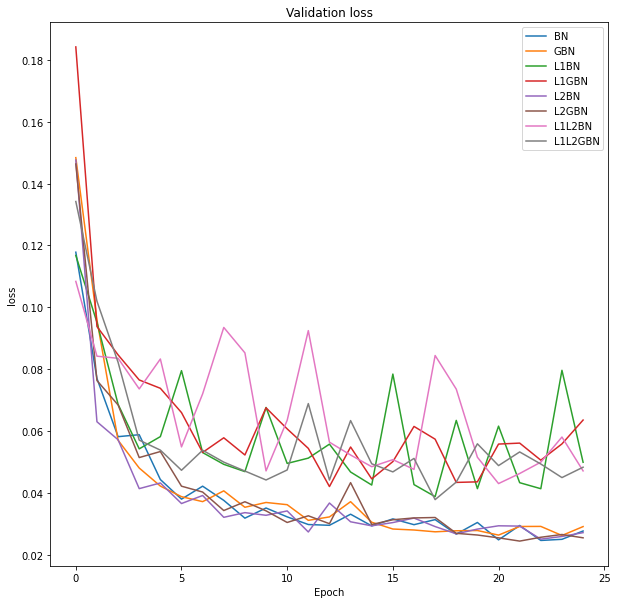

In [0]:
plot_matrix(matrix_data, "loss")

##Accuracy Curves #Plot

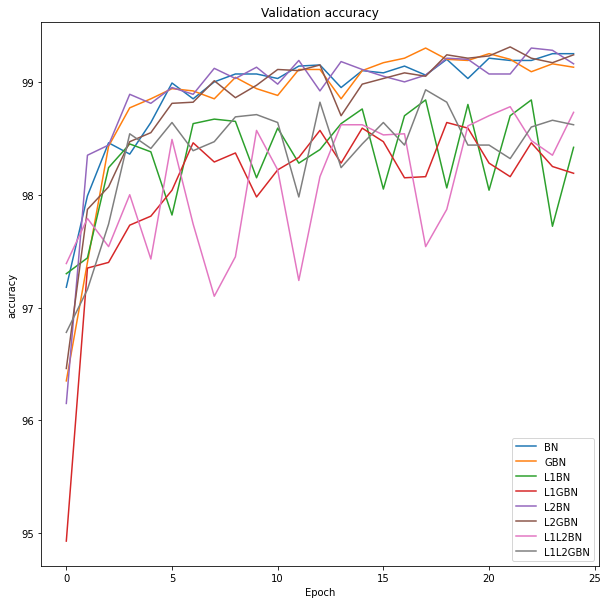

In [0]:
plot_matrix(matrix_data, "accuracy")